In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
import matplotlib.pyplot as plt

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

import backends.plot as plot

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
#  Inputs config

cWtil_vals = [0, -0.4, -0.2, 0.2, 0.4]
#cWtil_vals = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
#cWtil_vals = [0, -0.4, 0.4]

cWtil_eval_vals = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

input_fnames = {}
input_fnames [0   ] = "../Data/SM_EWK_1M_rivet_output.pickle"

#  "../Data/SM_EWK_rivet_output.pickle"
#  "../Data/SM_EWK_500k_rivet_output.pickle"
#  "../Data/SM_EWK_1M_rivet_output.pickle"

input_fnames [-0.4] = "../Data/cWtil_m0p4_full_200k_rivet_output.pickle"
input_fnames [-0.3] = "../Data/cWtil_m0p3_full_200k_rivet_output.pickle"
input_fnames [-0.2] = "../Data/cWtil_m0p2_full_200k_rivet_output.pickle"
input_fnames [-0.1] = "../Data/cWtil_m0p1_full_200k_rivet_output.pickle"
input_fnames [ 0.1] = "../Data/cWtil_0p1_full_200k_rivet_output.pickle"
input_fnames [ 0.2] = "../Data/cWtil_0p2_full_200k_rivet_output.pickle"
input_fnames [ 0.3] = "../Data/cWtil_0p3_full_200k_rivet_output.pickle"
input_fnames [ 0.4] = "../Data/cWtil_0p4_full_200k_rivet_output.pickle"


In [3]:
#  Model config

output_size_per_stage     = 15
max_epochs                = 50
batch_size                = 200
epoch_increase_per_level  = 20
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.5

white_linear_fraction_data  = 0.3
white_linear_fraction_gauss = 0.
whitening_num_points        = 200
whitening_func_form         = "step"
whitening_alpha, whitening_beta, whitening_gamma = 3, 2, 2

load_whitening_funcs = ".whitening_funcs.pickle"    # ".whitening_funcs.pickle"
save_whitening_funcs = None   # ".whitening_funcs.pickle"

load_model_dir = None     # ".EWK_density_model"
save_model_dir = None     # ".EWK_density_model"

learning_rate = 0.001     # 0.01 for SGD or 0.001 otherwise
optimiser     = "adam"     # SGD, Adam or AdaDelta

In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [5]:
#  Load and format the data
#

data_tables = {}
for cWtil in cWtil_eval_vals :
    input_fname = input_fnames [cWtil]
    print(f"Creating data table for cWtil={cWtil}")
    print(f" -- events from file {input_fname}")
    data = DataTable(input_fname)
    print(f" -- Table created with {data.get_num_events()} events")
    for observable, limits in observable_limits.items() :
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    print(" -- ordering observables")
    data.reorder(*observables_order)
    data.print_summary()
    data_tables [cWtil] = data
    

Creating data table for cWtil=0
 -- events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 642591 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 642591 events s

 -- 128530 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 128530 events survived
 -- removing observable N_jets
 -- removing observable pT_ll
 -- removing observable rap_ll
 -- removing observable theta_ll
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | m_jj     | <class 'float'> |
    | 1      | m_ll     | <class 'float'> |
    | 2      | Dphi_j_j | <class 'float'> |
    | 3      | Dy_j_j   | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.1468         |
    +

 -- 132342 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132326 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132326 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130576 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128713 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128713 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128713 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128713 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128683 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 128598 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128598 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 128598 events survived
 -- filtering observable N_jets between 2 and 5
 -- 128598 e

In [6]:

whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data, white_linear_fraction_gauss] for key in data.keys]

observable_data, weight_data, white_data_to_fit = {}, {}, {}
for cWtil in cWtil_vals :
    data = data_tables [cWtil]
    #  Seperate data from weights
    observable_data [cWtil], weight_data [cWtil] = data.get_observables_and_weights()
    #  Whiten data
    print(f"Whitening dataset for cWtil={cWtil}")
    white_data_to_fit[cWtil], whitening_funcs = whiten_axes (observable_data[cWtil], data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights(), 
                                                             func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)

if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))

weights_to_fit = {k:i/np.sum(i) for k,i in weight_data.items()}


Loading whitening functions from file .whitening_funcs.pickle
Whitening dataset for cWtil=0
Whitening dataset for cWtil=-0.4
Whitening dataset for cWtil=-0.2
Whitening dataset for cWtil=0.2
Whitening dataset for cWtil=0.4


In [7]:
#  Weight edges more highly to reduce interpolation bias

weights_to_fit = {k:(1+np.fabs(k)/np.max(np.fabs(cWtil_vals)))*i/np.sum(i) for k,i in weight_data.items()}


Filter efficiency is 100.000%


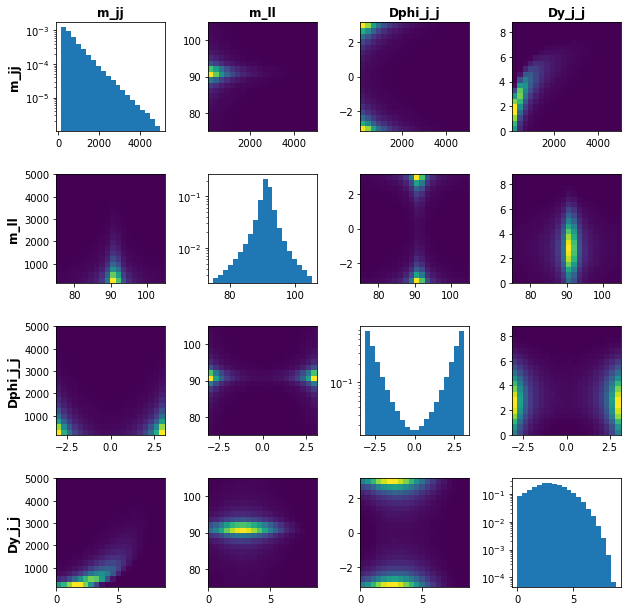

Filter efficiency is 100.000%


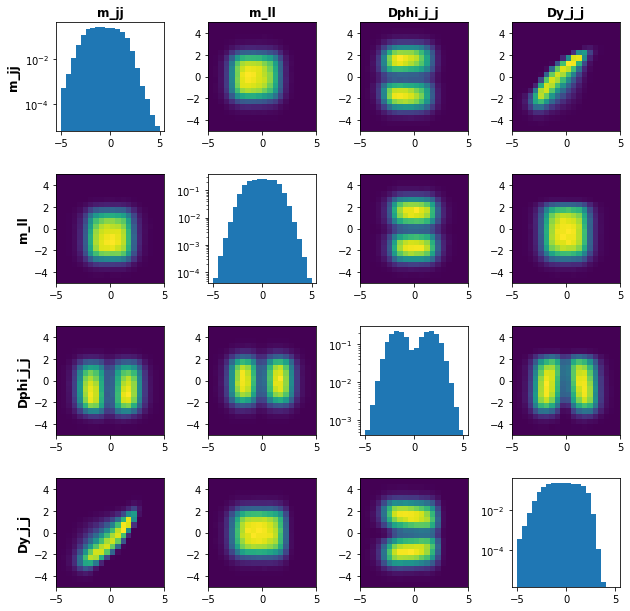

In [8]:

plot_data(observable_data  [0], weight_data   [0], keys=data.keys, bins=20, lims=True)
plot_data(white_data_to_fit[0], weights_to_fit[0], keys=data.keys, bins=20, lims=False)


In [9]:
#  Load model if requested, otherwise build and fit
#

if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #  Create density model
    density_model = DensityModel(name            = "EWK_density_model", 
                                 num_gaussians   = output_size_per_stage, 
                                 num_conditions  = 1, 
                                 num_observables = data.get_num_observables(), 
                                 types           = data.types,
                                 int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                 verbose         = True,
                                 learning_rate   = learning_rate,
                                 optimiser       = optimiser)
    fit_times = {}
    for obs_idx in range(white_data_to_fit[0].shape[1]) :
        fit_start_time = time.time()
        num_epochs = max_epochs + obs_idx*epoch_increase_per_level
        density_model.fit(white_data_to_fit, 
                          weights_to_fit,
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : EWK_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 15
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 4
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.build          Building model segment: EWK_density_model_observable0 for observable index 0
Creating continuous density model: EWK_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 15
Instructions for updating:
Colocations handled automatically by placer.
Model: "EWK_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i

Model: "EWK_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 7)            14          input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 6)            18          input_5[0][0]                    
______________________________________________________________________

INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 50
INFO       DensityModel.fit              -  Training setting: batch_size = 200
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 578773 samples, validate on 578774 samples
Epoch 1/50
578773/578773 [==============================] - 23s 40us/step - loss: 1.2324e-05 - val_loss: 1.1761e-05
Epoch 2/50
578773/578773 [==============================] - 20s 34us/step - loss: 1.1720e-05 - val_loss: 1.1653e-05
Epoch 3/50
578773/578773 [==============================] - 20s 35us/step - loss: 1.1648e-05 - val_loss: 1.1656e-05
Epoch 4/50
578773/578773 [==============================] - 21s 37us/step - loss: 1.1647e-05 - val_loss: 1.1647e-

578773/578773 [==============================] - 22s 38us/step - loss: 1.2919e-05 - val_loss: 1.2941e-05
Epoch 17/90
578773/578773 [==============================] - 23s 40us/step - loss: 1.2919e-05 - val_loss: 1.2940e-05
Epoch 18/90
578773/578773 [==============================] - 24s 41us/step - loss: 1.2919e-05 - val_loss: 1.2939e-05
Epoch 19/90
578773/578773 [==============================] - 23s 40us/step - loss: 1.2919e-05 - val_loss: 1.2939e-05
Epoch 20/90
578773/578773 [==============================] - 24s 41us/step - loss: 1.2919e-05 - val_loss: 1.2939e-05
Epoch 21/90
578773/578773 [==============================] - 23s 40us/step - loss: 1.2919e-05 - val_loss: 1.2938e-05
Epoch 22/90
578773/578773 [==============================] - 24s 41us/step - loss: 1.2918e-05 - val_loss: 1.2939e-05
Epoch 23/90
578773/578773 [==============================] - 22s 37us/step - loss: 1.2918e-05 - val_loss: 1.2939e-05
Epoch 24/90
578773/578773 [==============================] - 23s 41us/step -

578773/578773 [==============================] - 16s 27us/step - loss: 8.1185e-06 - val_loss: 8.1491e-06
Epoch 42/110
578773/578773 [==============================] - 16s 27us/step - loss: 8.1178e-06 - val_loss: 8.1652e-06
Epoch 43/110
578773/578773 [==============================] - 16s 27us/step - loss: 8.1184e-06 - val_loss: 8.1406e-06
Epoch 44/110
578773/578773 [==============================] - 16s 27us/step - loss: 8.1168e-06 - val_loss: 8.1461e-06
Epoch 45/110
578773/578773 [==============================] - 16s 27us/step - loss: 8.1179e-06 - val_loss: 8.1416e-06
Epoch 46/110
578773/578773 [==============================] - 16s 27us/step - loss: 8.1171e-06 - val_loss: 8.1378e-06
Epoch 47/110
578773/578773 [==============================] - 16s 27us/step - loss: 8.1169e-06 - val_loss: 8.1393e-06
Epoch 48/110
578773/578773 [==============================] - 16s 27us/step - loss: 8.1168e-06 - val_loss: 8.1389e-06
Epoch 49/110
578773/578773 [==============================] - 16s 28u

In [10]:
#  Use this cell to add training epochs to whichever indices appear undertrained

'''improve_indices   = [i for i in range(num_observables)]
impove_batch_size = 5000
impove_num_epochs = 200
improve_patience  = 10
improve_validation_split = 0.5

added_fit_times = {}
for obs_idx in improve_indices :
    fit_start_time = time.time()
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = impove_num_epochs,
                      early_stopping_patience   = improve_patience,
                      validation_split          = improve_validation_split,
                      batch_size_per_observable = impove_batch_size)
    added_fit_times [obs_idx] = [impove_num_epochs, time.time() - fit_start_time]
    '''

'improve_indices   = [i for i in range(num_observables)]\nimpove_batch_size = 5000\nimpove_num_epochs = 200\nimprove_patience  = 10\nimprove_validation_split = 0.5\n\nadded_fit_times = {}\nfor obs_idx in improve_indices :\n    fit_start_time = time.time()\n    density_model.fit(white_data_to_fit, \n                      weights_to_fit,\n                      observable                = obs_idx,\n                      max_epochs_per_observable = impove_num_epochs,\n                      early_stopping_patience   = improve_patience,\n                      validation_split          = improve_validation_split,\n                      batch_size_per_observable = impove_batch_size)\n    added_fit_times [obs_idx] = [impove_num_epochs, time.time() - fit_start_time]\n    '

In [11]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [12]:
#  Generate a large number of datapoints
#

'''n_gen = 100000

fake_white_datapoints = {}
for cWtil in cWtil_eval_vals :
    n_gen = n_gen # len(observable_data[cWtil])
    print(f"Generating {n_gen} fake datapoints for cWtil={cWtil}")
    start = time.time()
    fake_white_datapoints[cWtil] = density_model.sample(n_gen, [cWtil])
    end = time.time()
    print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#
print("Unwhitening the generated datapoints")
fake_datapoints = {}
for cWtil in cWtil_eval_vals :
    print(f"Unwhitening generated datapoints for cWtil={cWtil}")
    fake_datapoints [cWtil] = unwhiten_axes(fake_white_datapoints[cWtil], whitening_funcs)'''


'n_gen = 100000\n\nfake_white_datapoints = {}\nfor cWtil in cWtil_eval_vals :\n    n_gen = n_gen # len(observable_data[cWtil])\n    print(f"Generating {n_gen} fake datapoints for cWtil={cWtil}")\n    start = time.time()\n    fake_white_datapoints[cWtil] = density_model.sample(n_gen, [cWtil])\n    end = time.time()\n    print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")\n\n#  Unwhiten generated data\n#\nprint("Unwhitening the generated datapoints")\nfake_datapoints = {}\nfor cWtil in cWtil_eval_vals :\n    print(f"Unwhitening generated datapoints for cWtil={cWtil}")\n    fake_datapoints [cWtil] = unwhiten_axes(fake_white_datapoints[cWtil], whitening_funcs)'

In [13]:
#  Generate a large number of datapoints at 0.
#

n_gen = 5000

print(f"Generating {n_gen} fake datapoints for cWtil=[0]")
start = time.time()

fake_white_datapoints_SM = density_model.sample(n_gen, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for cWtil=0")
start = time.time()
fake_datapoints_SM = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at cWtil=0 in {int(end-start):.0f}s")


n_gen = 500000

print(f"Generating {n_gen} fake datapoints for cWtil=[0]")
start = time.time()

fake_white_datapoints_SM_big = density_model.sample(n_gen, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for cWtil=0")
start = time.time()
fake_datapoints_SM_big = unwhiten_axes(fake_white_datapoints_SM_big, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at cWtil=0 in {int(end-start):.0f}s")


Generating 5000 fake datapoints for cWtil=[0]
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 5000 datapoints, observable index is 3
5000 datapoints generated at cWtil=0 in 4s
Unwhitening fake datapoints for cWtil=0
5000 datapoints unwhitened at cWtil=0 in 0s
Generating 500000 fake datapoints for cWtil=[0]
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 242s
Unwhitening fake datapoints 

In [14]:
#  Get datapoint likelihoods at 0 hypothesis
#

fake_datapoint_SM_likelihood = density_model.evaluate(0, fake_white_datapoints_SM)

fake_datapoint_weights = {}
for cWtil in cWtil_eval_vals :
    start = time.time()
    fake_datapoint_weights [cWtil] = density_model.evaluate(cWtil, fake_white_datapoints_SM) / fake_datapoint_SM_likelihood
    end = time.time()
    print(f"{len(fake_white_datapoints_SM)} datapoints evaluated at cWtil = {cWtil} in {(end-start):.2f}s")
    start = time.time()
    dataset_NLL = density_model.get_NLL(cWtil, fake_white_datapoints_SM)
    end = time.time()
    print(f"-- NLL = {dataset_NLL}, eval time is {(end-start):.2f}s")


5000 datapoints evaluated at cWtil = 0 in 3.20s
-- NLL = 6.647248796653747, eval time is 0.49s
5000 datapoints evaluated at cWtil = -0.4 in 3.15s
-- NLL = 6.6395321501731885, eval time is 0.48s
5000 datapoints evaluated at cWtil = -0.3 in 3.13s
-- NLL = 6.642936103248596, eval time is 0.47s
5000 datapoints evaluated at cWtil = -0.2 in 3.12s
-- NLL = 6.64603372335434, eval time is 0.47s
5000 datapoints evaluated at cWtil = -0.1 in 3.23s
-- NLL = 6.648973544788361, eval time is 0.50s
5000 datapoints evaluated at cWtil = 0.1 in 3.19s
-- NLL = 6.6439204215049745, eval time is 0.49s
5000 datapoints evaluated at cWtil = 0.2 in 3.17s
-- NLL = 6.638989613723755, eval time is 0.47s
5000 datapoints evaluated at cWtil = 0.3 in 3.14s
-- NLL = 6.63370309343338, eval time is 0.48s
5000 datapoints evaluated at cWtil = 0.4 in 3.16s
-- NLL = 6.633067556858063, eval time is 0.52s


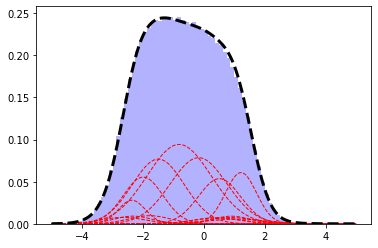

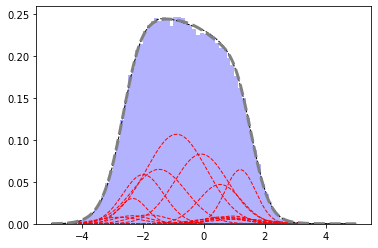

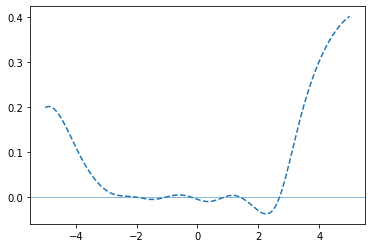

In [15]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

import matplotlib.pyplot as plt
from scipy import stats

params = density_model.likelihood_models[0].get_gauss_params([0])[0]
fracs  = params[:output_size_per_stage]
means  = params[output_size_per_stage:2*output_size_per_stage]
sigmas = params[2*output_size_per_stage:3*output_size_per_stage]

x = np.linspace(-5, 5, 201)
y1 = 0.
plt.hist(white_data_to_fit[0][:,0], weights=weights_to_fit[0], density=True, color="blue", alpha=0.3, bins=np.linspace(-5, 5, 81))
for i in range(output_size_per_stage) :
    yp = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
    plt.plot(x, yp, c="r", linewidth=1, linestyle="--")
    y1 = y1 + yp
plt.plot(x, y1, c="k", linewidth=3, linestyle="--")
plt.show()

params = density_model.likelihood_models[0].get_gauss_params([0.4])[0]
fracs  = params[:output_size_per_stage]
means  = params[output_size_per_stage:2*output_size_per_stage]
sigmas = params[2*output_size_per_stage:3*output_size_per_stage]

y2 = 0.
plt.hist(white_data_to_fit[0.4][:,0], weights=weights_to_fit[0.4], density=True, color="blue", alpha=0.3, bins=np.linspace(-5, 5, 81))
for i in range(output_size_per_stage) :
    yp = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
    plt.plot(x, yp, c="r", linewidth=1, linestyle="--")
    y2 = y2 + yp
plt.plot(x, y1, c="k", linewidth=1, linestyle="--")
plt.plot(x, y2, c="grey", linewidth=3, linestyle="--")
plt.show()

plt.plot(x, (y2-y1)/y1, "--")
plt.axhline(0, linewidth=0.5)
plt.show()


Filter efficiency is 100.000%


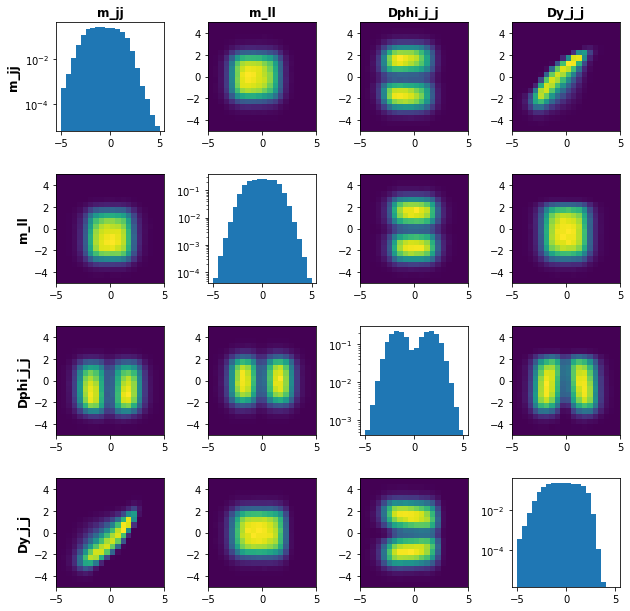

Filter efficiency is 100.000%


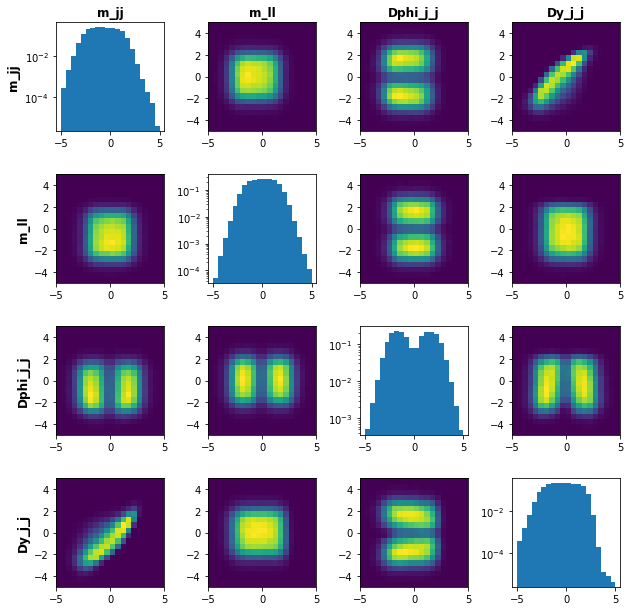

In [16]:
#  Plot original and generate data (total phase space)

plot_data(white_data_to_fit[0]        , weights_to_fit[0], keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints_SM_big, None             , keys=data.keys, bins=20, lims=False)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value enco

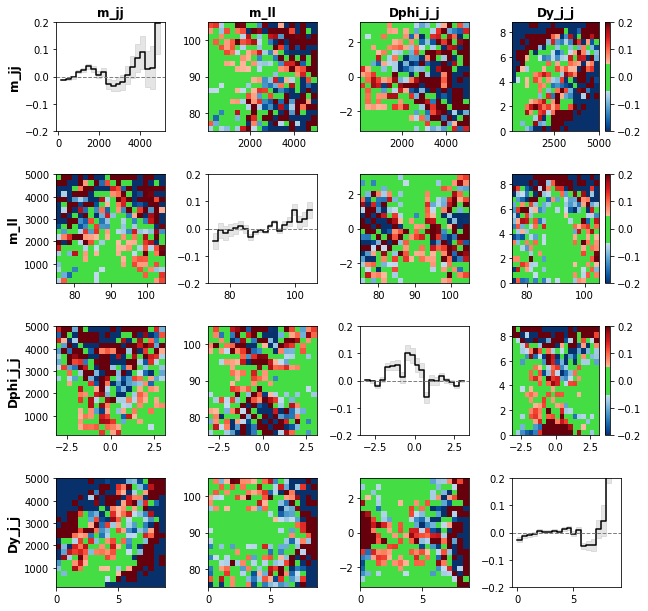

In [17]:
#  Plot ratio and pull between original and generated data (total phase space)

plot_ratio(observable_data[0]  , fake_datapoints_SM_big, weights_to_fit[0], None, keys=data.keys, bins=20)


In [18]:

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable (observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    print(f"Numerator filter efficiency is {100.*np.sum(filtered_weights_num)/np.sum(weights_num):.3f}%")
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    print(f"Denominator filter efficiency is {100.*np.sum(filtered_weights_den)/np.sum(weights_den):.3f}%")
    
    obs_idx = keys.index(observable)
    
    if lims : 
        obs_lims = observable_limits[observable]
    else :
        obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(observable, weight="bold", fontsize=12)
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    
    #ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.2, color="grey")
    
    ax.axhline(0 , linestyle="-", c="grey", linewidth=2)
    ax.axhline(0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.set_ylim([-0.9, 0.9])
    
    if type(label) != type(None) :
        ax.legend(loc="upper right", frameon=False, fontsize=16)
    
    plt.show()

In [19]:
#  Plot the datapoints provided
#
def get_eff (data, weights=None, keys=[], cuts=[]) :
    if type(weights) == type(None) :
        weights = np.ones(shape=(data.shape[0],))
    filtered_data, filtered_weights = data, weights
    for cut in cuts :
        filtered_data, filtered_weights = filter_data (filtered_data, filtered_weights, keys, cut[0], cut[1], cut[2])
    return 100.*np.sum(filtered_weights)/np.sum(weights), 100.*np.sqrt(np.sum(filtered_weights*filtered_weights))/np.sum(weights)


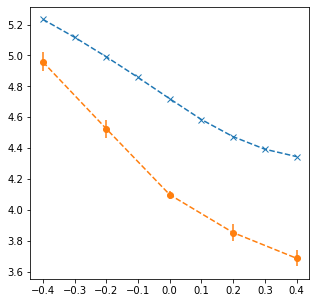

In [20]:
#  Plot data (VBF fiducial)

cuts = []
cuts.append(["m_jj"    , 1000, 5000])
cuts.append(["Dy_j_j"  , 2   , 8.8 ])
cuts.append(["Dphi_j_j", 0   , 1.5 ])

x1, x2, y1, y2, ey2 = [], [], [], [], []

for cWtil in sorted(cWtil_eval_vals) :
    e1 = get_eff(fake_datapoints_SM, weights=fake_datapoint_weights[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x1.append(cWtil)
    y1.append(e1[0])
    
for cWtil in sorted(cWtil_vals) :
    e2 = get_eff(observable_data[cWtil], weights_to_fit[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x2.append(cWtil)
    y2.append(e2[0])
    ey2.append(e2[1])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, y1, "x--")
ax.errorbar(x2, y2, yerr=ey2, fmt="o--")
plt.show()

In [21]:

#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    if ebar :ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.3, color="grey")
    ax.set_xlim([bins[0], bins[-1]])
    
    ax.axhline(0    , linestyle="-" , c="grey", linewidth=2  )
    for h in [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4] :
        ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)
        

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


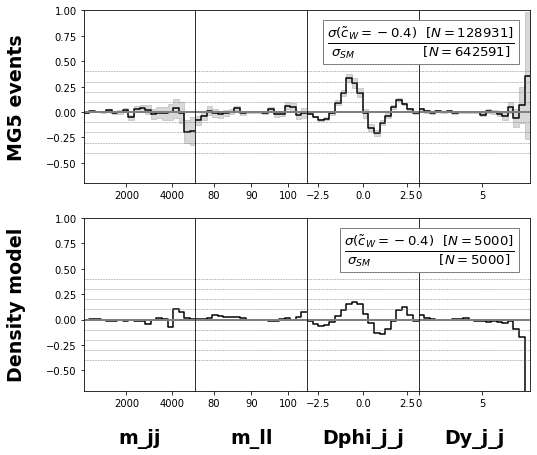

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


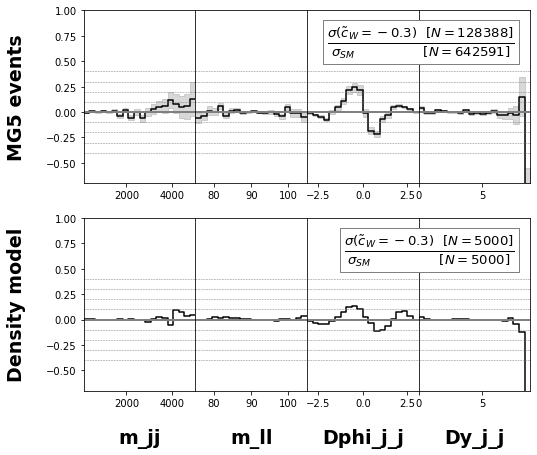

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


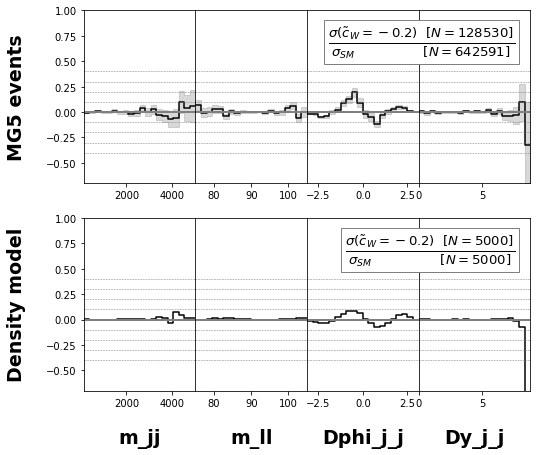

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


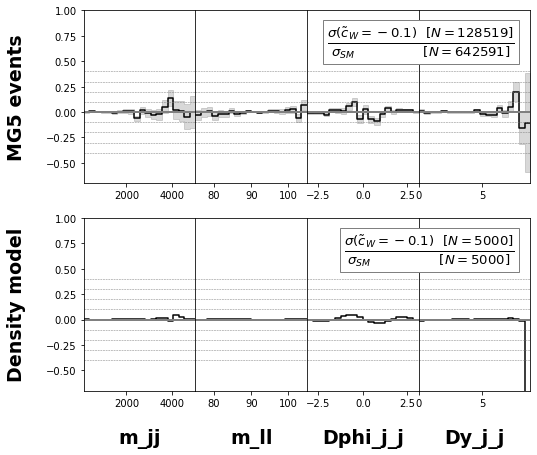

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


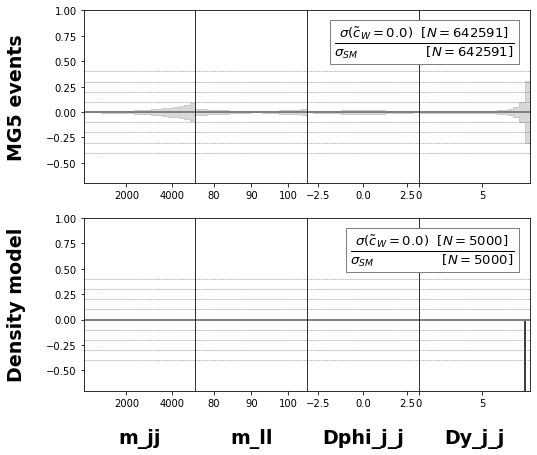

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


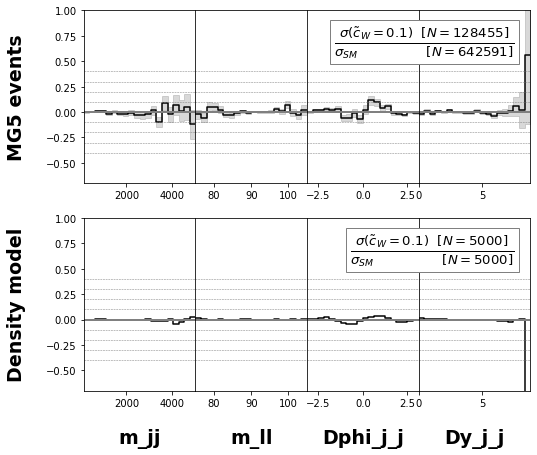

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


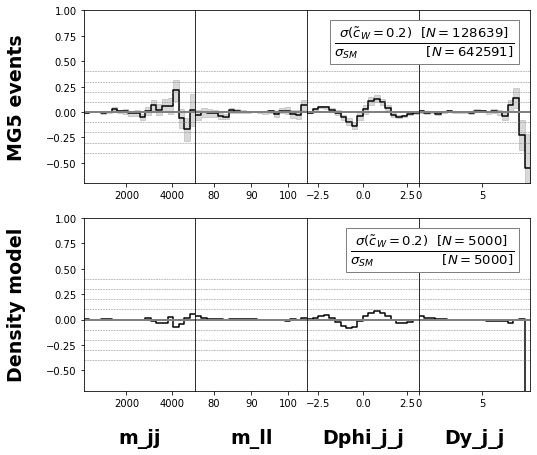

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


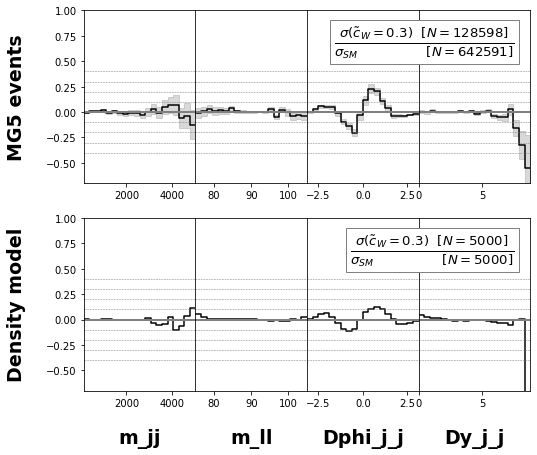

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1


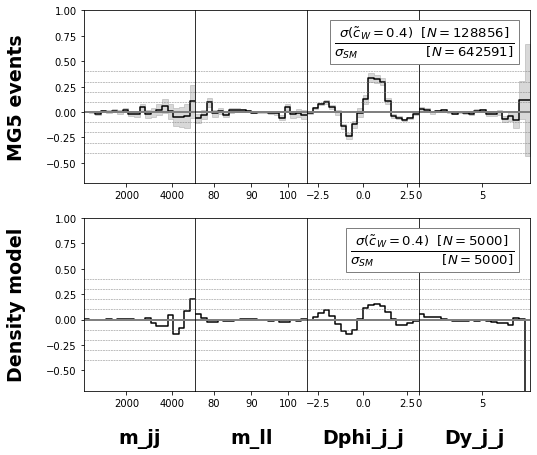

In [22]:

for fig_idx, cWtil in enumerate(sorted(cWtil_eval_vals)) :
    fig = plt.figure(figsize=(2*num_observables, 7))
    for idx, obs in enumerate(observables_order) :
        ax1 = fig.add_subplot(2, num_observables, 1+idx)
        data = data_tables [cWtil]
        observables, weights = data.get_observables_and_weights()
        plot_observable_on_axis (ax1, obs, observables, observable_data[0], weights, weights_to_fit[0], keys=data.keys, bins=20, normed=True, ebar=True)
        ax2 = fig.add_subplot(2, num_observables, num_observables+1+idx)
        plot_observable_on_axis (ax2, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[cWtil], fake_datapoint_weights[0], keys=data.keys, bins=20, normed=True)
        ax2.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
        if idx == 0 :
            ax1.set_ylabel("MG5 events"   , fontsize=19, labelpad=20, weight="bold")
            ax2.set_ylabel("Density model", fontsize=19, labelpad=20, weight="bold")
        else :
            ax1.set_yticks([])
            ax2.set_yticks([])
        if idx == num_observables-1 :
            ax1.text(0.86, 0.92, r"$\frac{\sigma({\tilde c}_W="+f"{cWtil:.1f})~~[N={observables.shape[0]}]"+r"}{\sigma_{SM}"+f"~~~~~~~~~~~~~~~~[N={observable_data[0].shape[0]}]"+"}$"       , fontsize=19, transform=ax1.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=4.0))
            ax2.text(0.86, 0.92, r"$\frac{\sigma({\tilde c}_W="+f"{cWtil:.1f})~~[N={fake_datapoints_SM.shape[0]}]"+r"}{\sigma_{SM}"+f"~~~~~~~~~~~~~~~~[N={fake_datapoints_SM.shape[0]}]"+"}$", fontsize=19, transform=ax2.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=4.0))
        ax1.set_ylim([-0.7, 1.])
        ax2.set_ylim([-0.7, 1.])
    plt.subplots_adjust(wspace=0)
    plt.savefig(f"figures/EWK_cWtil_dependence_{fig_idx}.png", bbox_inches="tight")
    plt.show()


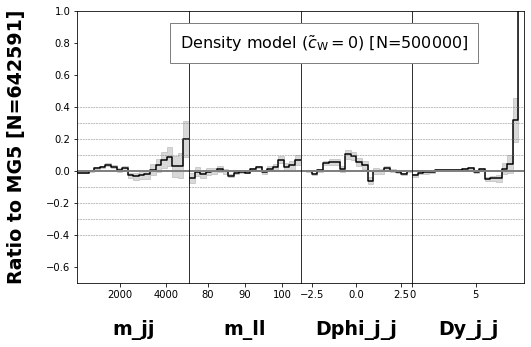

In [23]:

fig = plt.figure(figsize=(2*num_observables, 5))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(1, num_observables, 1+idx)
    datapoints_true, weights_true = data_tables [0].get_observables_and_weights()
    plot_observable_on_axis (ax, obs, fake_datapoints_SM_big, datapoints_true, None, weights_true, keys=data.keys, bins=20, normed=True, ebar=True)
    ax.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
    if idx == 0 :
        ax.set_ylabel(f"Ratio to MG5 [N={datapoints_true.shape[0]}]", fontsize=19, labelpad=20, weight="bold")
    else :
        ax.set_yticks([])
    if idx == num_observables-1 :
        ax.text(0.5, 0.92, r"${\rm Density~model}~({\tilde c}_{\rm W}="+f"0)$ [N={fake_datapoints_SM_big.shape[0]}]", fontsize=16, transform=ax.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=10.0))
    ax.set_ylim([-0.7, 1.])
plt.subplots_adjust(wspace=0)
plt.savefig(f"figures/EWK_ratio_at_SM.pdf", bbox_inches="tight")
plt.show()
